Epoch 1/25
7/7 [==============================] - 8s 104ms/step - loss: 0.1916
Epoch 2/25
7/7 [==============================] - 1s 108ms/step - loss: 0.0564
Epoch 3/25
7/7 [==============================] - 1s 129ms/step - loss: 0.0520
Epoch 4/25
7/7 [==============================] - 1s 108ms/step - loss: 0.0375
Epoch 5/25
7/7 [==============================] - 1s 107ms/step - loss: 0.0315
Epoch 6/25
7/7 [==============================] - 1s 108ms/step - loss: 0.0284
Epoch 7/25
7/7 [==============================] - 1s 108ms/step - loss: 0.0276
Epoch 8/25
7/7 [==============================] - 1s 105ms/step - loss: 0.0271
Epoch 9/25
7/7 [==============================] - 1s 103ms/step - loss: 0.0271
Epoch 10/25
7/7 [==============================] - 1s 105ms/step - loss: 0.0265
Epoch 11/25
7/7 [==============================] - 1s 108ms/step - loss: 0.0227
Epoch 12/25
7/7 [==============================] - 1s 127ms/step - loss: 0.0234
Epoch 13/25
7/7 [==============================] 

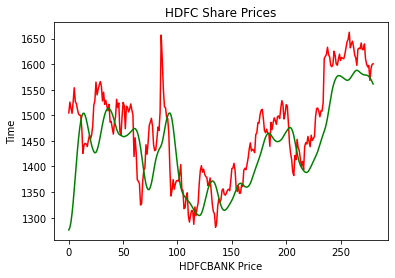

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
from nsepy import get_history
import datetime as dt
import numpy as np

from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM

tickers="HDFCBANK"
data = get_history(symbol=tickers,
                   start=dt.datetime(2018,12,1),   #get data using nsepy module
                   end=dt.datetime(2020,1,15))
#preparing/scaling the data
scaler= MinMaxScaler(feature_range=(0,1))   #scale to compress lowest and highest close value between 0 and 1
scaled_data=scaler.fit_transform(data['Close'].values.reshape(-1,1))  #since we're predicting closing prices only

pred_days=60               #no. of days we take into consideration for prediction (last 60)

x_train=[]
y_train=[]
#print(len(scaled_data))
for x in range(pred_days, len(scaled_data)):   #index 60 to the end of the data
            x_train.append(scaled_data[x-pred_days:x ,0])  #we take the data of the last 60 days plus the next value to train (60)
            y_train.append(scaled_data[x,0])

#converting this to numpy arrays
x_train, y_train= np.array(x_train), np.array(y_train)
#print(x_train)
x_train= np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))  #add a new dimension

#build the model, made of alternating layers
model=Sequential() #The Sequential class allows you to create a linear stack of layers by passing a list of layer instances to the constructor (create layers in the NN)
model.add(LSTM(units=50, return_sequences=True, input_shape=(x_train.shape[1], 1)))  #no. of units and layers in the NN can be modified, however, by adding more layers, you'll have to train longer as well as run the risk of overfitting
#return_sequences for an LSTM is always true as its feeback goes to the layer above, not forward
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=50))
model.add(Dropout(0.2))
model.add(Dense(units=1))  #This will hold the prediction of the next closing value

model.compile(optimizer='adam', loss='mean_squared_error')   #loss function, optimizer=
model.fit(x_train, y_train, epochs=25, batch_size=32)  #the model will see the same data 24 times, seeing 32 units at once

# Testing the data, for which we load training data

tickers="HDFCBANK"
test_data = get_history(symbol=tickers,
                   start=dt.datetime(2021,12,1),   #get data using nsepy module
                   end=dt.datetime(2023,1,15))
actual_prices= test_data['Close'].values
total_dataset= pd.concat((data['Close'], test_data['Close']))
model_inputs= total_dataset[len(total_dataset)- len(test_data)- pred_days:].values
model_inputs=model_inputs.reshape(-1,1)
model_inputs= scaler.transform(model_inputs)   #scaling data down with the scaler that we already have

#Make Predictions

x_test=[]

for x in range(pred_days, len(model_inputs)):
  x_test.append(model_inputs[x-pred_days:x ,0])

x_test = np.array(x_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))   #reshaping is to keep the data in the same format

pred_prices= model.predict(x_test)   #the pred prices are scaled, so we reverse scale them as below
pred_prices= scaler.inverse_transform(pred_prices)  #inverse transform

#Predict the next day
real_data= [model_inputs[len(model_inputs + 1 - pred_days:len(model_inputs)+1), 0]]
real_data= np.array(real_data)
real_data= np.reshape(real_data, (real_data.shape[0], real_data.shape[1]), 1)

prediction= model.predict(real_data)
prediction= scaler.inverse_transform(prediction)

print(f"Prediction: {prediction}")

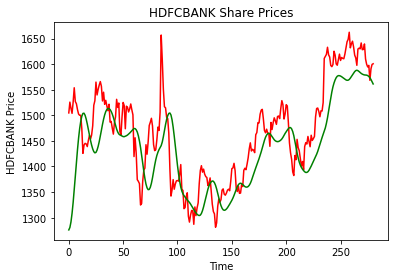

In [ ]:
#plot the test predictions
plt.plot(actual_prices, color="red", label=f"Actual {tickers} price")
plt.plot(pred_prices, color="green", label=f"Predicted {tickers} price")
plt.title(f"{tickers} Share Prices")
plt.xlabel("Time")
plt.ylabel(f"{tickers} Price")
plt.show()

In [ ]:
!pip install tensorflow

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
